# Preprocess data for QNLP pipeline
Remove all the sentences that cannot be parsed by BobcatParser

In [1]:
import collections
import pickle
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
import os
from random import shuffle
import re
import spacy
from discopy.tensor import Tensor
from discopy import Word
from discopy.rigid import Functor
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import random, unique
from lambeq import AtomicType, IQPAnsatz, remove_cups, NumpyModel, spiders_reader
from lambeq import BobcatParser, TreeReader, cups_reader, DepCCGParser
from lambeq import Dataset
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import TketModel
from lambeq import SpacyTokeniser
from pytket.extensions.qiskit import AerBackend
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('omw-1.4')

pd.set_option('display.width', 1000)
pd.options.display.max_colwidth=80
print(os.getcwd())
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
spacy.load('en_core_web_sm')

TOTAL_DATA_RATIO = 0.1 # only use part of the data
MAX_LENGTH = 10 # only use short tweets

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/peiyongw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/peiyongw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/peiyongw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/peiyongw/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/peiyongw/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/peiyongw/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/peiyongw/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


/home/peiyongw/Desktop/Hackathon-QNLP


**With stemming and lematization**

In [2]:
def get_sent_length(sent):
    if type(sent) is not str:
        return 9999999999999
    word_list = sent.split(" ")
    return len(word_list)

columns = ["Id","Entity","Target","Text"]
data = pd.read_csv(os.path.join(os.getcwd(),"data/twitter_training.csv"), names=columns,header=None)
#data = data.sample(frac=1).reset_index(drop=True)
data_val = pd.read_csv(os.path.join(os.getcwd(), "data/twitter_validation.csv"), names=columns,header=None)
#data_val = data.sample(frac=1).reset_index(drop=True)
df_train = data[["Text","Target"]]
df_train = df_train.loc[(df_train["Target"]=='Positive') | (df_train["Target"]=='Negative') & (df_train["Text"]!=np.nan)&(df_train["Text"].map(get_sent_length)<=MAX_LENGTH)]
df_train= df_train.drop_duplicates()
df_val = data_val[['Text', 'Target']]
df_val = df_val.loc[(df_val['Target'] == 'Positive') | (df_val['Target'] == 'Negative') & (df_val["Text"]!=np.nan)&(df_val["Text"].map(get_sent_length)<=MAX_LENGTH)]
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    
    without_emoji = emoji_pattern.sub(r'', text)
    
    tokens = word_tokenize(str(without_emoji).replace("'", "").lower()) 
    
    # Remove Puncs
    without_punc = [w for w in tokens if w.isalpha()]
    
    # Lemmatize
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_punc]
    # Stem
    text_cleaned = [PorterStemmer().stem(w) for w in text_len]
    
    return " ".join(text_cleaned)

df_train["Text"]= df_train["Text"].str.replace("im","i am")
df_train["Text"]= df_train["Text"].str.replace("i'm","i am")
df_train["Text"]= df_train["Text"].str.replace("I'm","i am")
df_train["Text"]= df_train["Text"].str.replace("it's","it is")
df_train["Text"]= df_train["Text"].str.replace("you're","you are")
df_train["Text"]= df_train["Text"].str.replace("hasn't","has not")
df_train["Text"]= df_train["Text"].str.replace("haven't","have not")
df_train["Text"]= df_train["Text"].str.replace("don't","do not")
df_train["Text"]= df_train["Text"].str.replace("doesn't","does not")
df_train["Text"]= df_train["Text"].str.replace("won't","will not")
df_train["Text"]= df_train["Text"].str.replace("shouldn't","should not")
df_train["Text"]= df_train["Text"].str.replace("can't","can not")
df_train["Text"]= df_train["Text"].str.replace("couldn't","could not")
df_val["Text"] = df_val["Text"].str.replace("im","i am")
df_val["Text"] = df_val["Text"].str.replace("i'm","i am")
df_val["Text"] = df_val["Text"].str.replace("I'm","i am")
df_val["Text"]= df_val["Text"].str.replace("it's","it is")
df_val["Text"]= df_val["Text"].str.replace("you're","you are")
df_val["Text"]= df_val["Text"].str.replace("hasn't","has not")
df_val["Text"]= df_val["Text"].str.replace("haven't","have not")
df_val["Text"] = df_val["Text"].str.replace("don't","do not")
df_val["Text"] = df_val["Text"].str.replace("doesn't","does not")
df_val["Text"] = df_val["Text"].str.replace("won't","will not")
df_val["Text"] = df_val["Text"].str.replace("shouldn't","should not")
df_val["Text"] = df_val["Text"].str.replace("can't","can not")
df_val["Text"] = df_val["Text"].str.replace("couldn't","could not")
df_train["Text"] = df_train["Text"].apply(preprocess)
df_val["Text"] = df_val["Text"].apply(preprocess)
df_train = df_train.dropna()
df_val = df_val.dropna()


# Positive sentiment to [0,1], negative sentiment to [1,0]
sentiment_train = []
sentiment_val = []
for i in df_train["Target"]:
    if i == "Positive":
        sentiment_train.append([0,1])
    else:
        sentiment_train.append([1,0])

df_train["Sentiment"] = sentiment_train
        
for i in df_val["Target"]:
    if i == "Positive":
        sentiment_val.append([0,1])
    else:
        sentiment_val.append([1,0])

df_val["Sentiment"] = sentiment_val

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25483 entries, 0 to 74681
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       25483 non-null  object
 1   Target     25483 non-null  object
 2   Sentiment  25483 non-null  object
dtypes: object(3)
memory usage: 796.3+ KB


In [4]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 6 to 998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       354 non-null    object
 1   Target     354 non-null    object
 2   Sentiment  354 non-null    object
dtypes: object(3)
memory usage: 11.1+ KB


In [5]:
df_train.head()

,Text,Target,Sentiment
0,i am get on borderland and i will murder you all,Positive,"[0, 1]"
1,i am come to the border and i will kill you all,Positive,"[0, 1]"
2,i am get on borderland and i will kill you all,Positive,"[0, 1]"
3,i am come on borderland and i will murder you all,Positive,"[0, 1]"
4,i am get on borderland and i will murder you me all,Positive,"[0, 1]"


In [6]:
df_val.head()

,Text,Target,Sentiment
6,thank you eamaddennfl new te austin hooper in the orang brown brown pic twit...,Positive,"[0, 1]"
7,rocket leagu sea of thief or rainbow six sieg i love play all three on strea...,Positive,"[0, 1]"
8,my as still knee deep in assassin creed odyssey with no way out anyti ame so...,Positive,"[0, 1]"
10,the profession dota scene is fuck explod and i complet welcom it get the gar...,Positive,"[0, 1]"
11,itch to assassin tccgif assassinscreedblackflag assassinscre thecapturedcoll...,Positive,"[0, 1]"


<AxesSubplot:xlabel='Target', ylabel='count'>

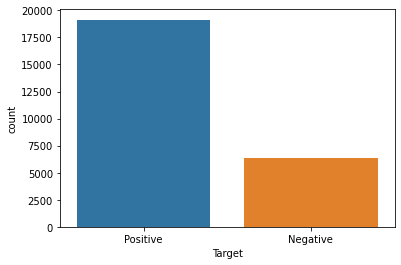

In [7]:
sns.countplot(x = "Target", data = df_train)

<AxesSubplot:xlabel='Target', ylabel='count'>

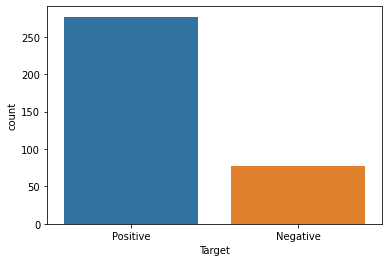

In [8]:
sns.countplot(x = "Target", data = df_val)

In [9]:
train_data_all, train_label_all, train_target_all = df_train["Text"].tolist(), df_train["Sentiment"].tolist(), df_train['Target'].tolist()
dev_data, dev_labels, dev_target = df_val["Text"].tolist(), df_val["Sentiment"].tolist(), df_val['Target'].tolist()
data = train_data_all+dev_data
labels = train_label_all+dev_labels
targets = train_target_all+dev_target
pairs = []
for c in zip(labels, data, targets):
    if len(c[1]) > 0:
        pairs.append(c)
random.seed(0)
random.shuffle(pairs)
N_EXAMPLES = len(pairs)
print("Total: {}".format(N_EXAMPLES))

Total: 25759


In [10]:
parser = BobcatParser(verbose='text')

In [11]:
new_data = []
new_label = []
new_target = []
i = 0 # positive
j = 0 # negative
for label, sent, target in tqdm(pairs):
    try:
        diag = parser.sentence2diagram(sent)
    except:
        pass
    else:
        sent_length = len(sent.split(" "))
        if i>round(N_EXAMPLES*TOTAL_DATA_RATIO)//2 and j>round(N_EXAMPLES*TOTAL_DATA_RATIO)//2:
            break
        if target == "Positive" and i<=round(N_EXAMPLES*TOTAL_DATA_RATIO)//2:
            new_data.append(sent)
            new_label.append(label)
            new_target.append(target)
            i = i + 1
        if target == 'Negative' and j<=round(N_EXAMPLES*TOTAL_DATA_RATIO)//2:
            new_data.append(sent)
            new_label.append(label)
            new_target.append(target)
            j = j + 1

cleaned_qnlp_data = {"data":new_data, "label":new_label, "target":new_target}

  0%|          | 0/25759 [00:00<?, ?it/s]

In [12]:
pickle.dump(cleaned_qnlp_data, open("cleaned_qnlp_data_stem_lematize.pkl", "wb" ))

**No stemming**

In [13]:
def get_sent_length(sent):
    if type(sent) is not str:
        return 9999999999999
    word_list = sent.split(" ")
    return len(word_list)

columns = ["Id","Entity","Target","Text"]
data = pd.read_csv(os.path.join(os.getcwd(),"data/twitter_training.csv"), names=columns,header=None)
#data = data.sample(frac=1).reset_index(drop=True)
data_val = pd.read_csv("/app/data/twitter_validation.csv", names=columns,header=None)
#data_val = data.sample(frac=1).reset_index(drop=True)
df_train = data[["Text","Target"]]
df_train = df_train.loc[(df_train["Target"]=='Positive') | (df_train["Target"]=='Negative') & (df_train["Text"]!=np.nan)&(df_train["Text"].map(get_sent_length)<=MAX_LENGTH)]
df_train= df_train.drop_duplicates()
df_val = data_val[['Text', 'Target']]
df_val = df_val.loc[(df_val['Target'] == 'Positive') | (df_val['Target'] == 'Negative') & (df_val["Text"]!=np.nan)&(df_val["Text"].map(get_sent_length)<=MAX_LENGTH)]
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    
    without_emoji = emoji_pattern.sub(r'', text)
    
    tokens = word_tokenize(str(without_emoji).replace("'", "").lower()) 
    
    # Remove Puncs
    without_punc = [w for w in tokens if w.isalpha()]
    
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_punc]
    
    return " ".join(text_len)

df_train["Text"]= df_train["Text"].str.replace("im","i am")
df_train["Text"]= df_train["Text"].str.replace("i'm","i am")
df_train["Text"]= df_train["Text"].str.replace("I'm","i am")
df_train["Text"]= df_train["Text"].str.replace("it's","it is")
df_train["Text"]= df_train["Text"].str.replace("you're","you are")
df_train["Text"]= df_train["Text"].str.replace("hasn't","has not")
df_train["Text"]= df_train["Text"].str.replace("haven't","have not")
df_train["Text"]= df_train["Text"].str.replace("don't","do not")
df_train["Text"]= df_train["Text"].str.replace("doesn't","does not")
df_train["Text"]= df_train["Text"].str.replace("won't","will not")
df_train["Text"]= df_train["Text"].str.replace("shouldn't","should not")
df_train["Text"]= df_train["Text"].str.replace("can't","can not")
df_train["Text"]= df_train["Text"].str.replace("couldn't","could not")
df_val["Text"] = df_val["Text"].str.replace("im","i am")
df_val["Text"] = df_val["Text"].str.replace("i'm","i am")
df_val["Text"] = df_val["Text"].str.replace("I'm","i am")
df_val["Text"]= df_val["Text"].str.replace("it's","it is")
df_val["Text"]= df_val["Text"].str.replace("you're","you are")
df_val["Text"]= df_val["Text"].str.replace("hasn't","has not")
df_val["Text"]= df_val["Text"].str.replace("haven't","have not")
df_val["Text"] = df_val["Text"].str.replace("don't","do not")
df_val["Text"] = df_val["Text"].str.replace("doesn't","does not")
df_val["Text"] = df_val["Text"].str.replace("won't","will not")
df_val["Text"] = df_val["Text"].str.replace("shouldn't","should not")
df_val["Text"] = df_val["Text"].str.replace("can't","can not")
df_val["Text"] = df_val["Text"].str.replace("couldn't","could not")
df_train["Text"] = df_train["Text"].apply(preprocess)
df_val["Text"] = df_val["Text"].apply(preprocess)
df_train = df_train.dropna()
df_val = df_val.dropna()


# Positive sentiment to [0,1], negative sentiment to [1,0]
sentiment_train = []
sentiment_val = []
for i in df_train["Target"]:
    if i == "Positive":
        sentiment_train.append([0,1])
    else:
        sentiment_train.append([1,0])

df_train["Sentiment"] = sentiment_train
        
for i in df_val["Target"]:
    if i == "Positive":
        sentiment_val.append([0,1])
    else:
        sentiment_val.append([1,0])

df_val["Sentiment"] = sentiment_val

FileNotFoundError: [Errno 2] No such file or directory: '/app/data/twitter_training.csv'

In [ ]:
train_data_all, train_label_all, train_target_all = df_train["Text"].tolist(), df_train["Sentiment"].tolist(), df_train['Target'].tolist()
dev_data, dev_labels, dev_target = df_val["Text"].tolist(), df_val["Sentiment"].tolist(), df_val['Target'].tolist()
data = train_data_all+dev_data
labels = train_label_all+dev_labels
targets = train_target_all+dev_target
pairs = []
for c in zip(labels, data, targets):
    if len(c[1]) > 0:
        pairs.append(c)
random.seed(0)
random.shuffle(pairs)
N_EXAMPLES = len(pairs)
print("Total: {}".format(N_EXAMPLES))

In [ ]:
new_data = []
new_label = []
new_target = []
i = 0 # positive
j = 0 # negative
for label, sent, target in tqdm(pairs):
    try:
        diag = parser.sentence2diagram(sent)
    except:
        pass
    else:
        sent_length = len(sent.split(" "))
        if target == "Positive" and i<=round(N_EXAMPLES*TOTAL_DATA_RATIO)//2:
            new_data.append(sent)
            new_label.append(label)
            new_target.append(target)
            i = i + 1
        if target == 'Negative' and j<=round(N_EXAMPLES*TOTAL_DATA_RATIO)//2:
            new_data.append(sent)
            new_label.append(label)
            new_target.append(target)
            j = j + 1
        
cleaned_qnlp_data = {"data":new_data, "label":new_label, "target":new_target}

In [ ]:
pickle.dump(cleaned_qnlp_data, open("cleaned_qnlp_data_lematize.pkl", "wb" ))

**Without stemming or lematization**

In [ ]:
def get_sent_length(sent):
    if type(sent) is not str:
        return 9999999999999
    word_list = sent.split(" ")
    return len(word_list)

columns = ["Id","Entity","Target","Text"]
data = pd.read_csv("/app/data/twitter_training.csv", names=columns,header=None)
#data = data.sample(frac=1).reset_index(drop=True)
data_val = pd.read_csv("/app/data/twitter_validation.csv", names=columns,header=None)
#data_val = data.sample(frac=1).reset_index(drop=True)
df_train = data[["Text","Target"]]
df_train = df_train.loc[(df_train["Target"]=='Positive') | (df_train["Target"]=='Negative') & (df_train["Text"]!=np.nan)&(df_train["Text"].map(get_sent_length)<=MAX_LENGTH)]
df_train= df_train.drop_duplicates()
df_val = data_val[['Text', 'Target']]
df_val = df_val.loc[(df_val['Target'] == 'Positive') | (df_val['Target'] == 'Negative') & (df_val["Text"]!=np.nan)&(df_val["Text"].map(get_sent_length)<=MAX_LENGTH)]
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    
    without_emoji = emoji_pattern.sub(r'', text)
    
    tokens = word_tokenize(str(without_emoji).replace("'", "").lower()) 
    
    # Remove Puncs
    without_punc = [w for w in tokens if w.isalpha()]
    
    # text_len = [WordNetLemmatizer().lemmatize(t) for t in without_punc]
    
    return " ".join(without_punc)

df_train["Text"]= df_train["Text"].str.replace("im","i am")
df_train["Text"]= df_train["Text"].str.replace("i'm","i am")
df_train["Text"]= df_train["Text"].str.replace("I'm","i am")
df_train["Text"]= df_train["Text"].str.replace("it's","it is")
df_train["Text"]= df_train["Text"].str.replace("you're","you are")
df_train["Text"]= df_train["Text"].str.replace("hasn't","has not")
df_train["Text"]= df_train["Text"].str.replace("haven't","have not")
df_train["Text"]= df_train["Text"].str.replace("don't","do not")
df_train["Text"]= df_train["Text"].str.replace("doesn't","does not")
df_train["Text"]= df_train["Text"].str.replace("won't","will not")
df_train["Text"]= df_train["Text"].str.replace("shouldn't","should not")
df_train["Text"]= df_train["Text"].str.replace("can't","can not")
df_train["Text"]= df_train["Text"].str.replace("couldn't","could not")
df_val["Text"] = df_val["Text"].str.replace("im","i am")
df_val["Text"] = df_val["Text"].str.replace("i'm","i am")
df_val["Text"] = df_val["Text"].str.replace("I'm","i am")
df_val["Text"]= df_val["Text"].str.replace("it's","it is")
df_val["Text"]= df_val["Text"].str.replace("you're","you are")
df_val["Text"]= df_val["Text"].str.replace("hasn't","has not")
df_val["Text"]= df_val["Text"].str.replace("haven't","have not")
df_val["Text"] = df_val["Text"].str.replace("don't","do not")
df_val["Text"] = df_val["Text"].str.replace("doesn't","does not")
df_val["Text"] = df_val["Text"].str.replace("won't","will not")
df_val["Text"] = df_val["Text"].str.replace("shouldn't","should not")
df_val["Text"] = df_val["Text"].str.replace("can't","can not")
df_val["Text"] = df_val["Text"].str.replace("couldn't","could not")
df_train["Text"] = df_train["Text"].apply(preprocess)
df_val["Text"] = df_val["Text"].apply(preprocess)
df_train = df_train.dropna()
df_val = df_val.dropna()


# Positive sentiment to [0,1], negative sentiment to [1,0]
sentiment_train = []
sentiment_val = []
for i in df_train["Target"]:
    if i == "Positive":
        sentiment_train.append([0,1])
    else:
        sentiment_train.append([1,0])

df_train["Sentiment"] = sentiment_train
        
for i in df_val["Target"]:
    if i == "Positive":
        sentiment_val.append([0,1])
    else:
        sentiment_val.append([1,0])

df_val["Sentiment"] = sentiment_val

In [ ]:
train_data_all, train_label_all, train_target_all = df_train["Text"].tolist(), df_train["Sentiment"].tolist(), df_train['Target'].tolist()
dev_data, dev_labels, dev_target = df_val["Text"].tolist(), df_val["Sentiment"].tolist(), df_val['Target'].tolist()
data = train_data_all+dev_data
labels = train_label_all+dev_labels
targets = train_target_all+dev_target
pairs = []
for c in zip(labels, data, targets):
    if len(c[1]) > 0:
        pairs.append(c)
random.seed(0)
random.shuffle(pairs)
N_EXAMPLES = len(pairs)
print("Total: {}".format(N_EXAMPLES))

In [ ]:
new_data = []
new_label = []
new_target = []
i = 0 # positive
j = 0 # negative
for label, sent, target in tqdm(pairs):
    try:
        diag = parser.sentence2diagram(sent)
    except:
        pass
    else:
        sent_length = len(sent.split(" "))
        if i>round(N_EXAMPLES*TOTAL_DATA_RATIO)//2 and j>round(N_EXAMPLES*TOTAL_DATA_RATIO)//2:
            break
        if target == "Positive" and i<=round(N_EXAMPLES*TOTAL_DATA_RATIO)//2:
            new_data.append(sent)
            new_label.append(label)
            new_target.append(target)
            i = i + 1
        if target == 'Negative' and j<=round(N_EXAMPLES*TOTAL_DATA_RATIO)//2:
            new_data.append(sent)
            new_label.append(label)
            new_target.append(target)
            j = j + 1

cleaned_qnlp_data = {"data":new_data, "label":new_label, "target":new_target}

In [ ]:
pickle.dump(cleaned_qnlp_data, open("cleaned_qnlp_data.pkl", "wb" ))